<a href="https://colab.research.google.com/github/juancarlosmontesdeoca/Boosting-Aprendizaje-Automatico/blob/main/Boosting_Algoritmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Boosting de Algoritmos Project**

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import random
import matplotlib.pyplot as plt



In [ ]:
url= "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"

In [ ]:
df = pd.read_csv(url)

**Planteamiento del Problema**

Dado un conjunto de datos clínicos previamente analizados mediante EDA, el objetivo es construir un modelo de clasificación basado en Random Forest que permita predecir la presencia o ausencia de enfermedad (Outcome). Se busca identificar las variables con mayor incidencia en el diagnóstico y evaluar el modelo mediante métricas de sensibilidad, especificidad y accuracy, con el fin de obtener una herramienta interpretable y util.

La variable Outcome es binaria, siendo:

Valor 1 = Enfermo
Valor 0 = Sano

Luego de la aplicacion del EDA en el Decision Tree, se llego a estas consideraciones:

-Pregnancies tiene una correlacion moderada de 0.54 con Age. Y ambas una correlacion de 0.22 y 0.24 con Outcome, respectivamente, por lo que cualquiera de las dos pudiera seleccionarse como variable predictora de Outcome.

-Glucose tiene una correlacion moderada baja de 0.33 con Insulin. Mientras que Glucose tiene una correlacion de 0.47 con Outcome, por lo que se usara Glucose como variable predictora de Outcome.

-Bmi tiene una correlacion con SkinThickness de 0.39, y de 0.29 con Outcome. Adicionalmente, tiene una correlacion de 0.28,   0.22 y 0.2 con BloodPressure, Glucose e Insulin, respectivamente, por lo tanto  BMI sera una de las variables predictoras.

Adicionalmente, se usara la variable DiabetesPedigreeFunction para predecir Outcome dada la importancia de dicha variable (indice genetica o hereditaria de tener diabetes), aun cuando su correlacion es relativamente baja con 0.17.

Se descartan el resto de las variables en virtud de las consideraciones anteriores.

Por lo tanto, las variables predictoras de Outcome seran: age, glucose, bmi, diabetespedigreefunction.

In [ ]:
df_reducido = df[['Age', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Outcome']]

In [ ]:
y = df_reducido['Outcome']
X = df_reducido.drop(columns='Outcome')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=124 )

In [ ]:
df_reducido['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


Corriendo el modelo de clases

In [ ]:
def grid_Adaboost(X_train, y_train):
    model = AdaBoostClassifier(random_state=0)
    n_estimators = [150, 200, 250, 300]
    learning_rate = [0.01, 0.1, 1, 0.001]
    grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                               scoring='roc_auc', error_score='raise')
    grid_result = grid_search.fit(X_train, y_train)
    return grid_result.best_estimator_

In [ ]:
best_model  = grid_Adaboost(X_train, y_train)
preds = best_model.predict(X_test)

In [ ]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       105
           1       0.68      0.78      0.72        49

    accuracy                           0.81       154
   macro avg       0.78      0.80      0.79       154
weighted avg       0.82      0.81      0.81       154



In [ ]:
best_model

AdaBoostClassifier(learning_rate=0.1, n_estimators=300, random_state=0)

Simulacion de Diferentes Escenarios, haciendole unos pequenos ajustes al modelo anterior

In [ ]:
def grid_Adaboost2(X_train, y_train, X_test, y_test):
    # Modelo base
    model = AdaBoostClassifier(random_state=0)

    # Hiperparámetros a explorar
    n_estimators = [150, 200, 250, 300, 500]
    learning_rate = [0.01, 0.1, 1, 0.001]

    grid = dict(n_estimators=n_estimators,
                learning_rate=learning_rate)

    # Validación cruzada
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)

    # Grid Search
    grid_search = GridSearchCV(estimator=model,
                               param_grid=grid,
                               n_jobs=-1,
                               cv=cv,
                               scoring='roc_auc',
                               error_score='raise')
    grid_search.fit(X_train, y_train)

    # Semilla fija para reproducibilidad
    random.seed(42)
    indices = random.sample(range(len(grid_search.cv_results_['params'])), 5)

    # Entrenar y evaluar algunos modelos del grid
    for i in indices:
        params = grid_search.cv_results_['params'][i]
        clf = AdaBoostClassifier(**params, random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        print(f"\n=== Reporte {i+1} con hiperparámetros:\n{params} ===")
        print(classification_report(y_test, preds, target_names=["No enfermo","Enfermo"]))

    # Mejor modelo encontrado
    best_model = grid_search.best_estimator_

    # Predicciones del mejor modelo
    preds = best_model.predict(X_test)

    # Reporte de clasificación del mejor modelo
    print("\n=== Classification Report del mejor modelo ===")
    print(classification_report(y_test, preds, target_names=["No enfermo","Enfermo"]))

    # Hiperparámetros usados
    params = {p: v for p, v in best_model.get_params().items()
              if p in ["n_estimators", "learning_rate"]}
    params_line = " : ".join([f"{k}: {v}" for k, v in params.items()])
    print("\n=== Hiperparámetros del mejor modelo ===")
    print(params_line)

    return best_model

# Uso
best_model = grid_Adaboost2(X_train, y_train, X_test, y_test)



=== Reporte 4 con hiperparámetros:
{'learning_rate': 0.01, 'n_estimators': 300} ===
              precision    recall  f1-score   support

  No enfermo       0.73      0.96      0.83        98
     Enfermo       0.84      0.38      0.52        56

    accuracy                           0.75       154
   macro avg       0.78      0.67      0.67       154
weighted avg       0.77      0.75      0.72       154


=== Reporte 1 con hiperparámetros:
{'learning_rate': 0.01, 'n_estimators': 150} ===
              precision    recall  f1-score   support

  No enfermo       0.73      0.96      0.83        98
     Enfermo       0.84      0.38      0.52        56

    accuracy                           0.75       154
   macro avg       0.78      0.67      0.67       154
weighted avg       0.77      0.75      0.72       154


=== Reporte 9 con hiperparámetros:
{'learning_rate': 0.1, 'n_estimators': 300} ===
              precision    recall  f1-score   support

  No enfermo       0.83      0.89    

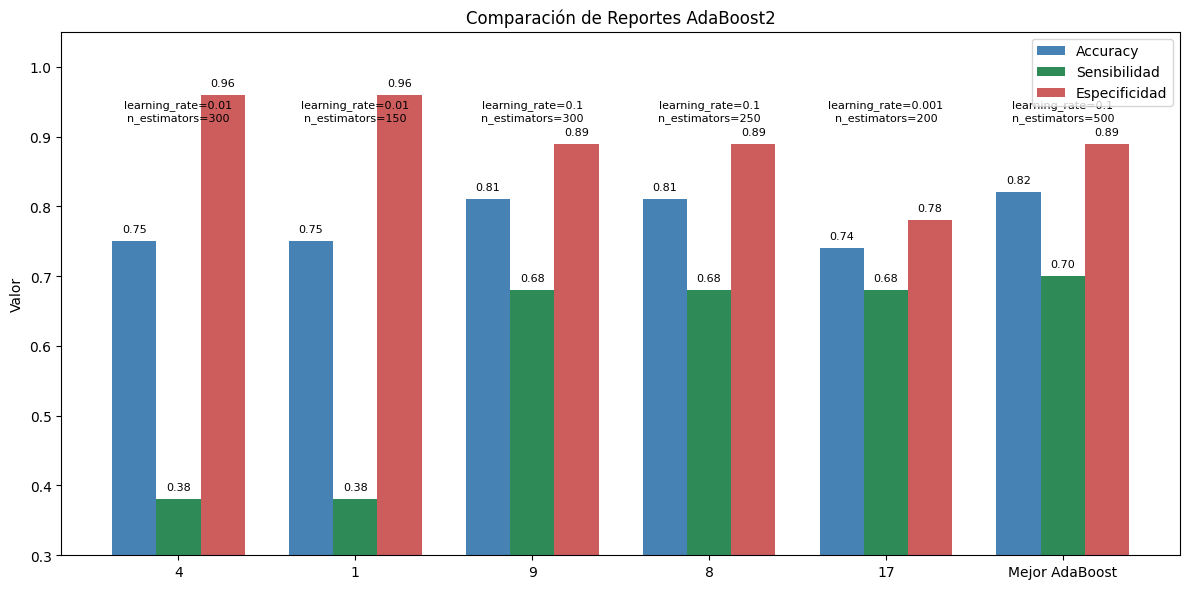

In [ ]:
# Datos de los reportes de AdaBoost2
# Datos actualizados de los reportes de AdaBoost2

data = [
    {"Reporte": "4", "Accuracy": 0.75, "Sensibilidad": 0.38, "Especificidad": 0.96,
     "Params": ["learning_rate=0.01", "n_estimators=300"]},
    {"Reporte": "1", "Accuracy": 0.75, "Sensibilidad": 0.38, "Especificidad": 0.96,
     "Params": ["learning_rate=0.01", "n_estimators=150"]},
    {"Reporte": "9", "Accuracy": 0.81, "Sensibilidad": 0.68, "Especificidad": 0.89,
     "Params": ["learning_rate=0.1", "n_estimators=300"]},
    {"Reporte": "8", "Accuracy": 0.81, "Sensibilidad": 0.68, "Especificidad": 0.89,
     "Params": ["learning_rate=0.1", "n_estimators=250"]},
    {"Reporte": "17", "Accuracy": 0.74, "Sensibilidad": 0.68, "Especificidad": 0.78,
     "Params": ["learning_rate=0.001", "n_estimators=200"]},
    {"Reporte": "Mejor AdaBoost", "Accuracy": 0.82, "Sensibilidad": 0.70, "Especificidad": 0.89,
     "Params": ["learning_rate=0.1", "n_estimators=500"]},
]

df = pd.DataFrame(data)

# Gráfico de barras agrupadas
x = range(len(df))
width = 0.25

plt.figure(figsize=(12,6))
bars_acc = plt.bar([i - width for i in x], df["Accuracy"], width=width, label="Accuracy", color="steelblue")
bars_sens = plt.bar(x, df["Sensibilidad"], width=width, label="Sensibilidad", color="seagreen")
bars_spec = plt.bar([i + width for i in x], df["Especificidad"], width=width, label="Especificidad", color="indianred")

# Etiquetas y formato
plt.xticks(x, df["Reporte"])
plt.ylim(0.3, 1.05)
plt.ylabel("Valor")
plt.title("Comparación de Reportes AdaBoost2")
plt.legend(loc="upper right")

# Mostrar valores arriba de cada barra
for bars in [bars_acc, bars_sens, bars_spec]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f"{height:.2f}", ha="center", va="bottom", fontsize=8)

# Mostrar hiperparámetros en 1 por línea
for i, params in enumerate(df["Params"]):
    text = "\n".join(params)
    plt.text(i, 0.92, text, ha="center", va="bottom", fontsize=8, rotation=0)

plt.tight_layout()
plt.show()



**Observaciones**

-La primera que salta a la vista, el modelo corrido en clases (Adaboost) versus el aplicado con la grilla (grid_Adaboost2), aun cuando tienen los mismos parametros y random_state, en muchas pruebas realizadas, no daba exactamente el mismo valor en todas las categorias. Explicar el por que puede ser esto

-Los hiperparametros (learning_rate y n_estimators) afectan la forma en que se corrigen errores, pero el impacto no siempre es lineal, incluso puede no variar, tal y como se observa en el reporte 1 y 4, que aun cuando n_estimators pasa de 150 a 300, mantiendo learning_rate = 0.01, las metricas son iguales en ambos modelos.

-Con un learning_rate muy bajo (0.001 o 0.01), el modelo aprende demasiado lento y no logra mejorar recall en la clase enfermos.

-Con learning_rate muy alto, el modelo aprende agresivamente, pero puede sobreajustar y perder estabilidad. En cambio, con un valor de 0.1, corrige lo suficiente sin volverse inestable, por eso el mejor resutlado fue con learning_rate = 0.1 y n_estimators = 300, donde se obtuvo un accuracy = 0.82 (82% de aciertos) y una sensibilidad de 0.70 (70% de acertar un enfermo dado que es enfermo).

-Surge una interrogante, del por que la especificidad es cercana o superior a 80% en todas las corridas. La especificidad en el caso de estudio, mide que tan bien detecta el modelo los no enfermos. En una base de datos con 500 (no enfermos) y 268 (enfermos), el modelo ve mas patrones de esa clase y se vuelve muy bueno en reconocerlos, de ahi que al ponderar errores, sigue encontrando facil corregir los casos de la clase mayoritaria. En cambio, la sensibilidad (recall de Enfermos) varia mas porque la clase minoritaria tiene menos ejemplos y es mas dificil de aprender.




**Conclusion**

-El desbalance de clases explica por que la especificidad se mantiene alta y la sensibilidad fluctua.

-Los hiperparametros ajustan la agresividad del aprendizaje, pero el patron se ve mas claro en el recall de los enfermos:
 *Un learning_rate muy bajo genera un recall pobre.
 *Un learning_rate muy alto mejora el recall pero arriesga estabilidad.
 *Un learning_rate de 0.1, genera un mejor balance entre sensibilidad y especificidad.

 -Y finalmente los resultados a traves del modelo Boosting, estan por encima de las metricas accuracy, sensbilidad y especificidad obtenidas por los modelos random forest y decision tree.